In [1]:
import os
import numpy as np
import sagemaker
from sagemaker.session import s3_input

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [2]:
hyperparams={'epochs': 30,
                 'learning-rate': 0.01,
                 'batch-size': 256,
                 'weight-decay': 2e-4,
                 'momentum': 0.9,
                 'optimizer': 'sgd'}

In [3]:
from sagemaker.tensorflow import TensorFlow

output_path = 's3://sagemaker-container-webinar/'
tf_estimator = TensorFlow(entry_point='cifar10-training-script-sagemaker.py', 
                          source_dir='code',
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          framework_version='1.13', 
                          py_version='py3',
                          script_mode=True,
                          output_path=output_path,
                          hyperparameters=hyperparams)

In [4]:
train_path = 's3://sagemaker-container-webinar/cifar10-dataset/train'
val_path = 's3://sagemaker-container-webinar/cifar10-dataset/validation'
eval_path = 's3://sagemaker-container-webinar/cifar10-dataset/eval'

tf_estimator.fit({'training': train_path,'validation': val_path,'eval': eval_path})

2019-08-08 23:17:19 Starting - Starting the training job...
2019-08-08 23:17:21 Starting - Launching requested ML instances......
2019-08-08 23:18:27 Starting - Preparing the instances for training...
2019-08-08 23:19:20 Downloading - Downloading input data
2019-08-08 23:19:20 Training - Downloading the training image......
2019-08-08 23:20:07 Training - Training image download completed. Training in progress.
2019-08-08 23:20:10,725 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-08-08 23:20:11,175 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "eval": "/opt/ml/input/data/eval",
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperpar

In [5]:
predictor = tf_estimator.deploy(initial_instance_count=1, instance_type='ml.c5.large')

---------------------------------------------------------------------------------------!

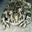

sample-img/1009_frog.png


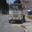

sample-img/1008_truck.png


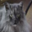

sample-img/1014_cat.png


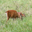

sample-img/1003_deer.png


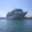

sample-img/1004_ship.png


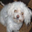

sample-img/1000_dog.png


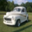

sample-img/1005_automobile.png


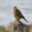

sample-img/1038_bird.png


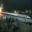

sample-img/1001_airplane.png


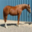

sample-img/1037_horse.png


In [6]:
from IPython.display import Image, display

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
images = []
for entry in os.scandir('sample-img'):
    if entry.is_file() and entry.name.endswith("png"):
        images.append('sample-img/' + entry.name)

for image in images:
    display(Image(image))
    print(image)

In [7]:
predictor.content_type = 'application/x-image'
predictor.serializer = None

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def get_prediction(file_path):
    
    with open(file_path, "rb") as image:
        f = image.read()
    b = bytearray(f)
    return labels[np.argmax(predictor.predict(b)['predictions'], axis=1)[0]]


In [8]:
predictions = [get_prediction(image) for image in images]

print('Predictions','\t\t\t','Ori')
for pred, actual in zip(predictions,images):
    print(pred,'\t\t\t',actual)

Predictions 			 Ori
frog 			 sample-img/1009_frog.png
automobile 			 sample-img/1008_truck.png
cat 			 sample-img/1014_cat.png
deer 			 sample-img/1003_deer.png
ship 			 sample-img/1004_ship.png
dog 			 sample-img/1000_dog.png
automobile 			 sample-img/1005_automobile.png
bird 			 sample-img/1038_bird.png
ship 			 sample-img/1001_airplane.png
horse 			 sample-img/1037_horse.png


In [9]:
tf_estimator.delete_endpoint()